In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Cell 1: install (run as shell)
!pip install streamlit sqlalchemy pillow folium streamlit-folium python-dotenv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 88.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.6/524.6 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.8 MB/s eta 0:00:00a 0:00:01


In [16]:
# Cell 2: DB + helpers (paste into a notebook cell and run)
import os, uuid
from datetime import datetime
from PIL import Image
from sqlalchemy import create_engine, Column, Integer, String, Float, DateTime, Text
from sqlalchemy.orm import declarative_base, sessionmaker
import folium

# config
DB_FILE = "civicconnect.db"
IMAGE_FOLDER = "uploads"
os.makedirs(IMAGE_FOLDER, exist_ok=True)

# SQLAlchemy setup
Base = declarative_base()
engine = create_engine(f"sqlite:///{DB_FILE}", connect_args={"check_same_thread": False})
SessionLocal = sessionmaker(bind=engine)

class Complaint(Base):
    __tablename__ = "complaints"
    id = Column(Integer, primary_key=True, index=True)
    complaint_id = Column(String, unique=True, index=True)
    name = Column(String)
    email = Column(String, index=True)
    title = Column(String)
    description = Column(Text)
    issue_type = Column(String)
    lat = Column(Float)
    lng = Column(Float)
    image_path = Column(String)
    status = Column(String, default="Pending")
    created_at = Column(DateTime, default=datetime.utcnow)
    updated_at = Column(DateTime, default=datetime.utcnow)
    assigned_to = Column(String, nullable=True)

Base.metadata.create_all(bind=engine)

def generate_complaint_id():
    return f"CC-{datetime.utcnow().strftime('%Y%m%d')}-{uuid.uuid4().hex[:6]}"

def save_pil_image(pil_img, complaint_id, ext=".png"):
    path = os.path.join(IMAGE_FOLDER, f"{complaint_id}{ext}")
    pil_img.save(path)
    return path

def add_complaint(name, email, title, description, issue_type, lat=None, lng=None, pil_image=None):
    session = SessionLocal()
    cid = generate_complaint_id()
    image_path = None
    if pil_image:
        image_path = save_pil_image(pil_image, cid)
    c = Complaint(
        complaint_id=cid, name=name or "Anonymous", email=email or "",
        title=title, description=description, issue_type=issue_type,
        lat=lat, lng=lng, image_path=image_path, status="Pending",
        created_at=datetime.utcnow(), updated_at=datetime.utcnow()
    )
    session.add(c); session.commit(); session.refresh(c); session.close()
    return c

def get_complaint_by_id(complaint_id):
    session = SessionLocal()
    r = session.query(Complaint).filter(Complaint.complaint_id==complaint_id).first()
    session.close()
    return r

def get_complaints_by_email(email, limit=50):
    session = SessionLocal()
    rows = session.query(Complaint).filter(Complaint.email==email).order_by(Complaint.created_at.desc()).limit(limit).all()
    session.close()
    return rows

def update_status(complaint_id, new_status, assigned_to=None):
    session = SessionLocal()
    r = session.query(Complaint).filter(Complaint.complaint_id==complaint_id).first()
    if not r:
        session.close(); return None
    r.status = new_status
    r.assigned_to = assigned_to
    r.updated_at = datetime.utcnow()
    session.add(r); session.commit()
    session.refresh(r); session.close()
    return r

def render_resolved_map(html_filename=None):
    session = SessionLocal()
    resolved = session.query(Complaint).filter(Complaint.status=="Resolved").all()
    session.close()
    if not resolved:
        # default map
        m = folium.Map(location=[20.5937,78.9629], zoom_start=5)
    else:
        pts = [(r.lat, r.lng) for r in resolved if r.lat and r.lng]
        if pts:
            avg_lat = sum([p[0] for p in pts])/len(pts)
            avg_lng = sum([p[1] for p in pts])/len(pts)
            m = folium.Map(location=[avg_lat, avg_lng], zoom_start=12)
            for r in resolved:
                if r.lat and r.lng:
                    popup = f"{r.title}<br>{r.issue_type}<br>{r.complaint_id}"
                    folium.Marker([r.lat,r.lng], popup=popup).add_to(m)
        else:
            m = folium.Map(location=[20.5937,78.9629], zoom_start=5)
    if html_filename:
        m.save(html_filename)
    return m


In [4]:
# Cell 3: Create dummy image and add a complaint
from PIL import Image, ImageDraw, ImageFont
# create dummy image
img = Image.new("RGB", (400,300), color=(200,200,200))
draw = ImageDraw.Draw(img)
draw.text((10,10), "Pothole Image (dummy)", fill=(0,0,0))
# Add complaint
c = add_complaint(
    name="Pooja",
    email="pooja@example.com",
    title="Pothole near library",
    description="Large pothole near the main library entrance.",
    issue_type="Pothole",
    lat=28.7041, lng=77.1025,
    pil_image=img
)
print("Inserted:", c.complaint_id, c.title, c.status, c.image_path)


Inserted: CC-20251025-a904d6 Pothole near library Pending uploads/CC-20251025-a904d6.png


Status: Pending Title: Pothole near library Updated: 2025-10-25 06:30:46.448629


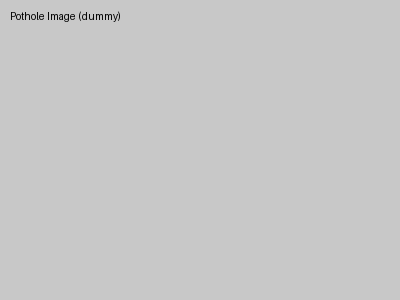

In [5]:
# Cell 4: Query by id and show image + data
cid = c.complaint_id  # from previous cell or paste an id
r = get_complaint_by_id(cid)
print("Status:", r.status, "Title:", r.title, "Updated:", r.updated_at)
display(Image.open(r.image_path))  # show image inline in notebook


In [6]:
# Cell 5: Update status to Resolved
updated = update_status(cid, "Resolved", assigned_to="Roads Dept")
print("Updated:", updated.complaint_id, updated.status, updated.assigned_to, updated.updated_at)


Updated: CC-20251025-a904d6 Resolved Roads Dept 2025-10-25 06:31:29.252238


In [7]:
# Cell 6: Render resolved map and show inline
m = render_resolved_map()
m  # If notebook supports folium rendering you'll see interactive map


In [14]:

## ✅ STEP 5: Kaggle → Streamlit Deployment Workflow
   !zip -r civic_tracker.zip civic_issue_tracker/


IndentationError: unexpected indent (2373624432.py, line 2)